# ECE 276C HW3 P1
Mingwei Xu A53270271

In [1]:
import gym
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch import nn, optim
from torch.distributions import Categorical

## Define Network

In [2]:
class PolicyNetwork(nn.Module):
    """
    Policy Network using MLP
    """
    def __init__(self, env):
        """
        :param env: object, gym environment
        """
        super(PolicyNetwork, self).__init__()
        # get state space and action space dimension
        self.state_space_n = env.observation_space.shape[0]
        self.action_space_n = env.action_space.n

        # define layers
        self.l1 = nn.Linear(self.state_space_n, 48)
        self.l2 = nn.Linear(48, self.action_space_n)

    def forward(self, x):
        """
        Feed forward
        
        :param x: np array, state
        :return: tensor, softmax probability of action
        """
        # build neural network
        network = nn.Sequential(
            self.l1,
            nn.Softmax(dim=-1),
            self.l2,
            nn.Softmax(dim=-1))

        return network(torch.FloatTensor(x).to(device))

## Choose Action

In [3]:
def choose_action(policy_network, state):
    """
    Choose action according to policy on given state

    :param policy_network: object, policy network
    :param state: np array, state
    :returns: int, action; tensor, log probability
    """
    probs = policy_network.forward(state)
    m = Categorical(probs)
    action = m.sample()
    log_prob = m.log_prob(action)
    return action.item(), log_prob

## Setup CUDA

In [4]:
# setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device :', device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

Using device : cpu


## Question 1.1

In [5]:
def reinforce(env, policy_network, batch_size=500, num_episodes=200, lr=0.01, gamma=0.99):
    """
    Policy gradient training using reinforce method

    :param env: object, gym environment
    :param policy_network: object, policy network
    :param batch_size: int, batch size
    :param num_episodes: int, number of episodes
    :param lr: float, learning rate
    :param gamma: float (0~1), discount factor
    :return: list of average reward on each episode
    """
    # setup place holders
    average_reward_list = []  # store step over episode

    # define optimizer
    optimizer = optim.Adam(policy_network.parameters(), 
                           lr=lr)

    # train
    for i in range(num_episodes):
        # setup placeholders for each batch
        batch_loss_sum = 0
        batch_traj_counter = 0
        batch_rewards = []

        # setup placeholders for each trajectory
        traj_rewards = []
        traj_log_prob_sum = 0

        # reset environment
        state = env.reset()
        done = False

        # batch
        for step in range(batch_size):
            # exploration
            action, log_prob = choose_action(policy_network, state)
            state_next, reward, done, _ = env.step(action)
            # env.render()

            # store data
            traj_rewards.append(reward)
            traj_log_prob_sum += log_prob

            # move on
            if done or (step == batch_size - 1):
                # trajectory or batch finished, update trajectory
                traj_discounted_return = torch.sum(torch.FloatTensor(traj_rewards).to(device) *
                                                   torch.FloatTensor([gamma ** t for t in range(1, len(traj_rewards) + 1)]).to(device))  # G(t)
                batch_loss_sum += traj_discounted_return * traj_log_prob_sum
                
                # reset state
                batch_rewards.append(np.sum(traj_rewards))
                batch_traj_counter += 1

                traj_rewards = []
                traj_log_prob_sum = 0

                state = env.reset()
            else:
                state = state_next

        # finish batch
        average_batch_reward = np.mean(batch_rewards)
        average_reward_list.append(average_batch_reward)
        loss = - batch_loss_sum / batch_traj_counter
        
        print('Episode [{}/{}] loss: {:.2f}, average reward: {:.2f}, trajectory num: {}'.format(i + 1, num_episodes,
                               loss.item(), average_batch_reward, batch_traj_counter))

        # update policy
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return average_reward_list

### Training

In [6]:
# setup environment
env = gym.make('CartPole-v1')
state = env.reset()

# setup network
policy_network = PolicyNetwork(env).to(device)

# train
average_reward_list = reinforce(env, policy_network, batch_size=500, num_episodes=200, lr=0.01, gamma=0.99)

Episode [1/200] loss: 495.15, average reward: 26.32, trajectory num: 19
Episode [2/200] loss: 760.13, average reward: 31.25, trajectory num: 16
Episode [3/200] loss: 504.33, average reward: 26.32, trajectory num: 19
Episode [4/200] loss: 321.91, average reward: 20.00, trajectory num: 25
Episode [5/200] loss: 328.67, average reward: 20.83, trajectory num: 24
Episode [6/200] loss: 393.64, average reward: 23.81, trajectory num: 21
Episode [7/200] loss: 251.14, average reward: 17.86, trajectory num: 28
Episode [8/200] loss: 345.46, average reward: 21.74, trajectory num: 23
Episode [9/200] loss: 405.71, average reward: 23.81, trajectory num: 21
Episode [10/200] loss: 316.34, average reward: 21.74, trajectory num: 23
Episode [11/200] loss: 247.03, average reward: 18.52, trajectory num: 27
Episode [12/200] loss: 433.30, average reward: 22.73, trajectory num: 22
Episode [13/200] loss: 403.35, average reward: 23.81, trajectory num: 21
Episode [14/200] loss: 228.80, average reward: 17.86, trajec

Episode [115/200] loss: 1738.58, average reward: 55.56, trajectory num: 9
Episode [116/200] loss: 1313.67, average reward: 50.00, trajectory num: 10
Episode [117/200] loss: 1222.12, average reward: 45.45, trajectory num: 11
Episode [118/200] loss: 1178.05, average reward: 45.45, trajectory num: 11
Episode [119/200] loss: 1087.67, average reward: 41.67, trajectory num: 12
Episode [120/200] loss: 1423.21, average reward: 50.00, trajectory num: 10
Episode [121/200] loss: 1728.06, average reward: 55.56, trajectory num: 9
Episode [122/200] loss: 1134.23, average reward: 45.45, trajectory num: 11
Episode [123/200] loss: 948.11, average reward: 38.46, trajectory num: 13
Episode [124/200] loss: 1192.51, average reward: 45.45, trajectory num: 11
Episode [125/200] loss: 2562.02, average reward: 71.43, trajectory num: 7
Episode [126/200] loss: 1331.60, average reward: 50.00, trajectory num: 10
Episode [127/200] loss: 1097.48, average reward: 45.45, trajectory num: 11
Episode [128/200] loss: 1627.

### Plot

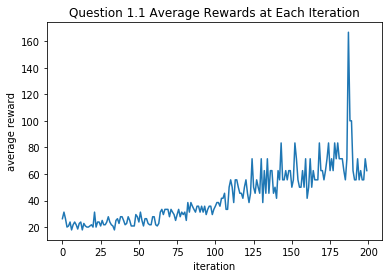

In [7]:
%matplotlib inline
plt.figure()
plt.plot(average_reward_list)
plt.xlabel('iteration')
plt.ylabel('average reward')
plt.title('Question 1.1 Average Rewards at Each Iteration')
plt.savefig('Question_1-1.png')
plt.show()

## Question 1.2

In [8]:
def reinforce_with_baseline(env, policy_network, batch_size=500, num_episodes=200, lr=0.01, gamma=0.99, enable_baseline=False):
    """
    Policy gradient training using modified reinforce method with baseline

    :param env: object, gym environment
    :param policy_network: object, policy network
    :param batch_size: int, batch size
    :param num_episodes: int, number of episodes
    :param lr: float, learning rate
    :param gamma: float (0~1), discount factor
    :param enable_baseline: bool, flag to enable baseline, defaults to False
    :return: list of average reward on each episode
    """
    # setup place holders
    average_reward_list = []  # store step over episode

    # define optimizer
    optimizer = optim.Adam(policy_network.parameters(), 
                           lr=lr)

    # train
    for i in range(num_episodes):
        # setup placeholders for each batch
        batch_loss_sum = 0
        batch_traj_counter = 0
        batch_rewards = []
        batch_log_prob_list = []
        batch_discounted_return_list = []

        # setup placeholders for each trajectory
        traj_rewards = []
        traj_log_prob_list = []

        # reset environment
        state = env.reset()
        done = False

        # batch
        for step in range(batch_size):
            # exploration
            action, log_prob = choose_action(policy_network, state)
            state_next, reward, done, _ = env.step(action)
            # env.render()

            # store data
            traj_rewards.append(reward)
            traj_log_prob_list.append(log_prob)

            # move on
            if done or (step == batch_size - 1):
                # trajectory or batch finished, update trajectory
                discounted_return_list = [sum([gamma ** (t_prime - t) * traj_rewards[t_prime] for t_prime in range(t, len(traj_rewards))]) \
                                          for t in range(1, len(traj_rewards) + 1)]

                # collect batch info
                batch_log_prob_list.extend(traj_log_prob_list)
                batch_discounted_return_list.extend(discounted_return_list)
                
                # reset state
                batch_rewards.append(np.sum(traj_rewards))
                batch_traj_counter += 1

                traj_rewards = []
                traj_log_prob_list = []

                state = env.reset()
            else:
                state = state_next

        # finish batch
        # subtract average returns if baseline is enabled
        if enable_baseline:
            batch_discounted_return_list -= np.mean(batch_discounted_return_list)
        
        # sum the traj loss by loop so we do not lose tensor gradient
        for step in range(len(batch_log_prob_list)):
            batch_loss_sum += batch_log_prob_list[step] * batch_discounted_return_list[step]
        
        
        average_batch_reward = np.mean(batch_rewards)
        average_reward_list.append(average_batch_reward)
        loss = - batch_loss_sum / batch_traj_counter
        
        print('Episode [{}/{}] loss: {:.2f}, average reward: {:.2f}, trajectory num: {}'.format(i + 1, num_episodes,
                               loss.item(), average_batch_reward, batch_traj_counter))

        # update policy
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return average_reward_list

### Training

In [9]:
# setup environment
env = gym.make('CartPole-v1')
state = env.reset()

# setup network
policy_network = PolicyNetwork(env).to(device)

# train
average_reward_list = reinforce_with_baseline(env, policy_network, batch_size=500, num_episodes=200, lr=0.01, gamma=0.99)

Episode [1/200] loss: 170.07, average reward: 21.74, trajectory num: 23
Episode [2/200] loss: 242.63, average reward: 22.73, trajectory num: 22
Episode [3/200] loss: 144.89, average reward: 20.00, trajectory num: 25
Episode [4/200] loss: 173.35, average reward: 20.83, trajectory num: 24
Episode [5/200] loss: 190.44, average reward: 23.81, trajectory num: 21
Episode [6/200] loss: 165.56, average reward: 20.83, trajectory num: 24
Episode [7/200] loss: 155.93, average reward: 20.00, trajectory num: 25
Episode [8/200] loss: 185.79, average reward: 21.74, trajectory num: 23
Episode [9/200] loss: 168.38, average reward: 21.74, trajectory num: 23
Episode [10/200] loss: 178.26, average reward: 20.83, trajectory num: 24
Episode [11/200] loss: 154.87, average reward: 20.83, trajectory num: 24
Episode [12/200] loss: 215.23, average reward: 23.81, trajectory num: 21
Episode [13/200] loss: 275.09, average reward: 26.32, trajectory num: 19
Episode [14/200] loss: 202.52, average reward: 23.81, trajec

Episode [114/200] loss: 2176.72, average reward: 100.00, trajectory num: 5
Episode [115/200] loss: 2010.98, average reward: 83.33, trajectory num: 6
Episode [116/200] loss: 1915.83, average reward: 83.33, trajectory num: 6
Episode [117/200] loss: 2286.34, average reward: 100.00, trajectory num: 5
Episode [118/200] loss: 1974.24, average reward: 83.33, trajectory num: 6
Episode [119/200] loss: 2313.67, average reward: 100.00, trajectory num: 5
Episode [120/200] loss: 1410.83, average reward: 71.43, trajectory num: 7
Episode [121/200] loss: 3378.59, average reward: 125.00, trajectory num: 4
Episode [122/200] loss: 5007.77, average reward: 166.67, trajectory num: 3
Episode [123/200] loss: 4121.91, average reward: 125.00, trajectory num: 4
Episode [124/200] loss: 3493.51, average reward: 125.00, trajectory num: 4
Episode [125/200] loss: 2385.52, average reward: 100.00, trajectory num: 5
Episode [126/200] loss: 2774.05, average reward: 100.00, trajectory num: 5
Episode [127/200] loss: 3389.

### Plot

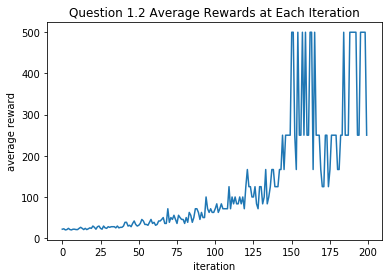

In [10]:
%matplotlib inline
plt.figure()
plt.plot(average_reward_list)
plt.xlabel('iteration')
plt.ylabel('average reward')
plt.title('Question 1.2 Average Rewards at Each Iteration')
plt.savefig('Question_1-2.png')
plt.show()

## Question 1.3                                                                                                         

### Training

In [11]:
# setup environment
env = gym.make('CartPole-v1')
state = env.reset()

# setup network
policy_network = PolicyNetwork(env).to(device)

# train
average_reward_list = reinforce_with_baseline(env, policy_network, batch_size=500, num_episodes=200, lr=0.01, gamma=0.99, enable_baseline=True)

Episode [1/200] loss: -0.06, average reward: 20.83, trajectory num: 24
Episode [2/200] loss: 0.12, average reward: 25.00, trajectory num: 20
Episode [3/200] loss: -0.36, average reward: 25.00, trajectory num: 20
Episode [4/200] loss: 0.04, average reward: 23.81, trajectory num: 21
Episode [5/200] loss: -0.24, average reward: 23.81, trajectory num: 21
Episode [6/200] loss: -0.46, average reward: 21.74, trajectory num: 23
Episode [7/200] loss: -0.69, average reward: 22.73, trajectory num: 22
Episode [8/200] loss: -0.27, average reward: 26.32, trajectory num: 19
Episode [9/200] loss: -0.47, average reward: 21.74, trajectory num: 23
Episode [10/200] loss: -0.52, average reward: 25.00, trajectory num: 20
Episode [11/200] loss: -0.84, average reward: 27.78, trajectory num: 18
Episode [12/200] loss: -0.69, average reward: 25.00, trajectory num: 20
Episode [13/200] loss: -1.26, average reward: 31.25, trajectory num: 16
Episode [14/200] loss: -1.06, average reward: 20.00, trajectory num: 25
Epi

Episode [115/200] loss: -27.91, average reward: 83.33, trajectory num: 6
Episode [116/200] loss: 7.84, average reward: 62.50, trajectory num: 8
Episode [117/200] loss: -18.85, average reward: 83.33, trajectory num: 6
Episode [118/200] loss: -77.20, average reward: 62.50, trajectory num: 8
Episode [119/200] loss: 26.40, average reward: 100.00, trajectory num: 5
Episode [120/200] loss: -16.57, average reward: 71.43, trajectory num: 7
Episode [121/200] loss: -2.73, average reward: 83.33, trajectory num: 6
Episode [122/200] loss: 7.66, average reward: 62.50, trajectory num: 8
Episode [123/200] loss: 19.21, average reward: 100.00, trajectory num: 5
Episode [124/200] loss: -15.48, average reward: 83.33, trajectory num: 6
Episode [125/200] loss: -11.23, average reward: 125.00, trajectory num: 4
Episode [126/200] loss: 11.82, average reward: 100.00, trajectory num: 5
Episode [127/200] loss: -3.26, average reward: 125.00, trajectory num: 4
Episode [128/200] loss: -17.44, average reward: 71.43, 

### Plot

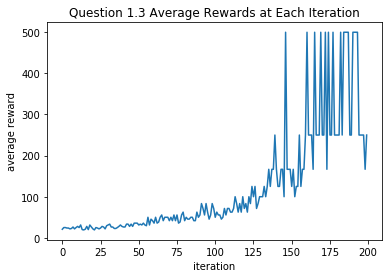

In [12]:
%matplotlib inline
plt.figure()
plt.plot(average_reward_list)
plt.xlabel('iteration')
plt.ylabel('average reward')
plt.title('Question 1.3 Average Rewards at Each Iteration')
plt.savefig('Question_1-3.png')
plt.show()

## Question 1.4

### Training

In [13]:
batch_size_list = [600, 800, 1000]
average_reward_list_final = []

for batch_size in batch_size_list:
    print('\n***** batch size = {} *****\n'.format(batch_size))
    # setup environment
    env = gym.make('CartPole-v1')
    state = env.reset()

    # setup network
    policy_network = PolicyNetwork(env).to(device)

    # train
    average_reward_list_final.append(reinforce_with_baseline(env, policy_network, batch_size=batch_size, num_episodes=200, lr=0.01, gamma=0.99,                                                                                 enable_baseline=True))


***** batch size = 600 *****

Episode [1/200] loss: 2.11, average reward: 22.22, trajectory num: 27
Episode [2/200] loss: 0.32, average reward: 18.18, trajectory num: 33
Episode [3/200] loss: 0.38, average reward: 22.22, trajectory num: 27
Episode [4/200] loss: 0.28, average reward: 20.00, trajectory num: 30
Episode [5/200] loss: -0.29, average reward: 20.69, trajectory num: 29
Episode [6/200] loss: 0.05, average reward: 20.69, trajectory num: 29
Episode [7/200] loss: -0.23, average reward: 18.75, trajectory num: 32
Episode [8/200] loss: -0.23, average reward: 23.08, trajectory num: 26
Episode [9/200] loss: -0.38, average reward: 22.22, trajectory num: 27
Episode [10/200] loss: -0.58, average reward: 23.08, trajectory num: 26
Episode [11/200] loss: -0.99, average reward: 28.57, trajectory num: 21
Episode [12/200] loss: -0.58, average reward: 22.22, trajectory num: 27
Episode [13/200] loss: -0.69, average reward: 23.08, trajectory num: 26
Episode [14/200] loss: -0.57, average reward: 2

Episode [115/200] loss: -20.96, average reward: 100.00, trajectory num: 6
Episode [116/200] loss: -27.05, average reward: 85.71, trajectory num: 7
Episode [117/200] loss: -18.05, average reward: 100.00, trajectory num: 6
Episode [118/200] loss: 13.64, average reward: 85.71, trajectory num: 7
Episode [119/200] loss: -25.41, average reward: 66.67, trajectory num: 9
Episode [120/200] loss: 48.41, average reward: 150.00, trajectory num: 4
Episode [121/200] loss: -70.93, average reward: 120.00, trajectory num: 5
Episode [122/200] loss: -68.83, average reward: 120.00, trajectory num: 5
Episode [123/200] loss: 11.90, average reward: 150.00, trajectory num: 4
Episode [124/200] loss: 7.30, average reward: 150.00, trajectory num: 4
Episode [125/200] loss: -9.32, average reward: 150.00, trajectory num: 4
Episode [126/200] loss: -123.41, average reward: 150.00, trajectory num: 4
Episode [127/200] loss: -56.48, average reward: 120.00, trajectory num: 5
Episode [128/200] loss: -22.87, average reward

Episode [27/200] loss: -1.58, average reward: 24.24, trajectory num: 33
Episode [28/200] loss: -1.95, average reward: 22.86, trajectory num: 35
Episode [29/200] loss: -2.92, average reward: 24.24, trajectory num: 33
Episode [30/200] loss: -1.52, average reward: 22.86, trajectory num: 35
Episode [31/200] loss: -2.59, average reward: 33.33, trajectory num: 24
Episode [32/200] loss: -3.12, average reward: 25.00, trajectory num: 32
Episode [33/200] loss: -3.44, average reward: 29.63, trajectory num: 27
Episode [34/200] loss: -1.48, average reward: 25.00, trajectory num: 32
Episode [35/200] loss: -1.73, average reward: 21.05, trajectory num: 38
Episode [36/200] loss: -2.92, average reward: 24.24, trajectory num: 33
Episode [37/200] loss: -1.36, average reward: 30.77, trajectory num: 26
Episode [38/200] loss: -1.33, average reward: 29.63, trajectory num: 27
Episode [39/200] loss: -5.46, average reward: 25.81, trajectory num: 31
Episode [40/200] loss: -2.51, average reward: 26.67, trajectory 

Episode [140/200] loss: -39.12, average reward: 160.00, trajectory num: 5
Episode [141/200] loss: -64.37, average reward: 114.29, trajectory num: 7
Episode [142/200] loss: 1.38, average reward: 133.33, trajectory num: 6
Episode [143/200] loss: -110.96, average reward: 160.00, trajectory num: 5
Episode [144/200] loss: -3.07, average reward: 160.00, trajectory num: 5
Episode [145/200] loss: -59.37, average reward: 200.00, trajectory num: 4
Episode [146/200] loss: -7.73, average reward: 133.33, trajectory num: 6
Episode [147/200] loss: -29.98, average reward: 266.67, trajectory num: 3
Episode [148/200] loss: -128.23, average reward: 266.67, trajectory num: 3
Episode [149/200] loss: -64.68, average reward: 160.00, trajectory num: 5
Episode [150/200] loss: -3.00, average reward: 400.00, trajectory num: 2
Episode [151/200] loss: -155.27, average reward: 266.67, trajectory num: 3
Episode [152/200] loss: 52.26, average reward: 266.67, trajectory num: 3
Episode [153/200] loss: 15.62, average re

Episode [52/200] loss: -8.80, average reward: 33.33, trajectory num: 30
Episode [53/200] loss: -9.88, average reward: 32.26, trajectory num: 31
Episode [54/200] loss: -7.26, average reward: 41.67, trajectory num: 24
Episode [55/200] loss: -11.00, average reward: 35.71, trajectory num: 28
Episode [56/200] loss: -12.79, average reward: 38.46, trajectory num: 26
Episode [57/200] loss: -10.05, average reward: 33.33, trajectory num: 30
Episode [58/200] loss: -7.47, average reward: 34.48, trajectory num: 29
Episode [59/200] loss: -10.92, average reward: 45.45, trajectory num: 22
Episode [60/200] loss: -9.88, average reward: 35.71, trajectory num: 28
Episode [61/200] loss: -7.95, average reward: 38.46, trajectory num: 26
Episode [62/200] loss: -12.19, average reward: 37.04, trajectory num: 27
Episode [63/200] loss: -8.53, average reward: 47.62, trajectory num: 21
Episode [64/200] loss: -9.13, average reward: 47.62, trajectory num: 21
Episode [65/200] loss: -6.67, average reward: 45.45, trajec

Episode [164/200] loss: 71.36, average reward: 500.00, trajectory num: 2
Episode [165/200] loss: -43.56, average reward: 333.33, trajectory num: 3
Episode [166/200] loss: -13.47, average reward: 333.33, trajectory num: 3
Episode [167/200] loss: 12.91, average reward: 333.33, trajectory num: 3
Episode [168/200] loss: 62.47, average reward: 333.33, trajectory num: 3
Episode [169/200] loss: -55.20, average reward: 250.00, trajectory num: 4
Episode [170/200] loss: -125.24, average reward: 200.00, trajectory num: 5
Episode [171/200] loss: -80.54, average reward: 333.33, trajectory num: 3
Episode [172/200] loss: 10.66, average reward: 333.33, trajectory num: 3
Episode [173/200] loss: -204.57, average reward: 250.00, trajectory num: 4
Episode [174/200] loss: -152.64, average reward: 500.00, trajectory num: 2
Episode [175/200] loss: 9.97, average reward: 250.00, trajectory num: 4
Episode [176/200] loss: -86.90, average reward: 250.00, trajectory num: 4
Episode [177/200] loss: 38.71, average re

### Plot

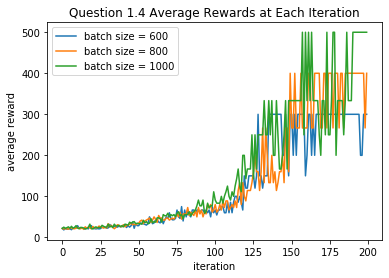

In [14]:
%matplotlib inline
plt.figure()
for average_reward_list in average_reward_list_final:
    plt.plot(average_reward_list)
plt.xlabel('iteration')
plt.ylabel('average reward')
plt.legend(['batch size = ' + str(batch_size) for batch_size in batch_size_list])
plt.title('Question 1.4 Average Rewards at Each Iteration')
plt.savefig('Question_1-4.png')
plt.show()